### <p style="text-align:center; font-size:24px;">🚆 Arrival To Exam Start</p>


###  Problem understanding

Every train rake in Indian Railways must undergo a safety examination upon yard arrival.Due to congestion and
resource issues, there’s often a delay between arrival and exam start.

This project uses historical data to model that delay and
help improve scheduling and yard efficiency.

Predict the exam start
time of a rake using its
actual arrival time and
related features.


Allocate resources
better

Reduce bottlenecks
and idle time

### Explore Data And Extract Main Features 

##### Packages

In [47]:
pip install numba pandas

Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [49]:
!pip install scikit-learn


In [50]:
!pip install xgboost


In [51]:
import pandas as pd
import numpy as np
from numba import njit
import time


##### Load Original Dataset

In [52]:
# 📁 Load dataset
df = pd.read_csv(r"D:\CRIS_PROJECT\AR_TO_EX_ST\_Narrow_the_dataset_early_using_CTEs_WITH_filtered_rake_details.csv")
print(f"✅ Loaded: {df.shape[0]} rows, {df.shape[1]} columns")


C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\965042737.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\CRIS_PROJECT\AR_TO_EX_ST\_Narrow_the_dataset_early_using_CTEs_WITH_filtered_rake_details.csv")


✅ Loaded: 587028 rows, 24 columns


##### Convert to datetime

In [53]:
# 🧼 Clean empty strings
df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

# 🕐 Convert to datetime
df['creation_date'] = pd.to_datetime(df['creation_date'], errors='coerce')
df['arrival_timestamp'] = pd.to_datetime(df['act_arrival_date'] + ' ' + df['act_arrival_time'], errors='coerce')
df['exam_start_timestamp'] = pd.to_datetime(df['exam_start_dt'] + ' ' + df['exam_start_tm'], errors='coerce')
df['exam_comp_timestamp']  = pd.to_datetime(df['exam_comp_dt'] + ' ' + df['exam_comp_tm'], errors='coerce')
df['dispatch_timestamp']   = pd.to_datetime(df['dispatch_date'] + ' ' + df['dispatch_time'], errors='coerce')

# 🚫 Drop 2022 data based on creation_date
df = df[~(df['arrival_timestamp'].dt.year == 2022)]
print(f"🗑️ Removed 2022 data. Remaining rows: {len(df)}")



🗑️ Removed 2022 data. Remaining rows: 587002


##### Consolidate Duplicates: Keep Highest Wagon Count for Each Rake and Creation Date Pair

In [54]:
# 🔁 Consolidate: Keep row with max total_wagons per (rake_id, creation_date)
df.sort_values(by=['rake_id', 'creation_date', 'total_wagons'], ascending=[True, True, False], inplace=True)
df_duplicates = df[df.duplicated(subset=['rake_id', 'creation_date'], keep='first')]

df = df.drop_duplicates(subset=['rake_id', 'creation_date'], keep='first').reset_index(drop=True)
print(f"✅ Consolidated data: {len(df)} rows")

✅ Consolidated data: 373584 rows


##### Calculate target column: Arrival to Exam Start

In [55]:
# 🎯 Calculate target: Arrival to Exam Start (in minutes)
df['ar_to_ex_st'] = (df['exam_start_timestamp'] - df['arrival_timestamp']).dt.total_seconds() / 60

# 📆 Create arrival date for grouping
df['arrival_date'] = df['arrival_timestamp'].dt.date

# ➕ Calculate yard_rakes_today
yard_rakes_td = df.groupby(['yard_id', 'arrival_date']).agg(
    yard_rakes_today=('rake_id', 'count')
).reset_index()

# 🔗 Merge yard_rakes_today back into df
df = df.merge(yard_rakes_td, on=['yard_id', 'arrival_date'], how='left')

# 🔢 Encode rake_id as numeric for congestion calculation
df['rake_id_num'] = df['rake_id'].astype('category').cat.codes
df['rakes_already_present'] = 0  # Initialize column


In [56]:
# ⚡ Numba-accelerated congestion function
@njit
def compute_rakes_already_present(arrival, dispatch, rake_ids, out):
    n = len(arrival)
    for i in range(n):
        for j in range(n):
            if i == j or rake_ids[i] == rake_ids[j]:
                continue
            if arrival[j] < arrival[i] and dispatch[j] > arrival[i]:
                out[i] += 1

# ⚙️ Apply yard-wise
df.sort_values(by=['yard_id', 'arrival_timestamp'], inplace=True)
for yard_id, group in df.groupby('yard_id'):
    idx = group.index.to_numpy()
    arrival  = df.loc[idx, 'arrival_timestamp'].values.astype(np.int64)
    dispatch = df.loc[idx, 'dispatch_timestamp'].values.astype(np.int64)
    rake_ids = df.loc[idx, 'rake_id_num'].values.astype(np.int64)

    out = np.zeros(len(idx), dtype=np.int32)
    compute_rakes_already_present(arrival, dispatch, rake_ids, out)
    df.loc[idx, 'rakes_already_present'] = out

##### Drop unnecessary columns

In [57]:
# 🧹 Drop unnecessary columns
df.drop(columns=[
    'act_arrival_date', 'act_arrival_time', 'dispatch_date', 'dispatch_time',
    'exam_start_dt', 'exam_start_tm', 'exam_comp_dt', 'exam_comp_tm',
    'bpc_date', 'brake_cyli', 'count_detached', 'count_discarded',
    'count_dispatched', 'count_dissipated', 'count_off_memo'
], inplace=True)

# ✅ Remove invalid target values
df_cleaned = df[df['ar_to_ex_st'].notna() & (df['ar_to_ex_st'] >= 0)].copy()
rows_dropped = len(df) - len(df_cleaned)

# 🧼 Final cleanup
df_cleaned.drop(columns=['rake_id_num'], inplace=True)

##### Save cleaned dataset

In [58]:
# 💾 Save cleaned dataset
final_path = r"D:\CRIS_PROJECT\AR_TO_EX_ST\Updated_dataset.csv"
df_cleaned.to_csv(final_path, index=False)

# 📢 Summary
print(f"\n✅ Total rows dropped due to invalid target: {rows_dropped}")
print(f"📊 Total rows in final data: {len(df_cleaned)}")
print(f"💾 Final dataset saved to: {final_path}")


✅ Total rows dropped due to invalid target: 0
📊 Total rows in final data: 373584
💾 Final dataset saved to: D:\CRIS_PROJECT\AR_TO_EX_ST\Updated_dataset.csv


##### Load the Updated dataset

In [59]:
import pandas as pd
# Load the updated dataset
df = pd.read_csv("Updated_dataset.csv") 
df.info()

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2851881942.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Updated_dataset.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373584 entries, 0 to 373583
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   yard_id                373584 non-null  object 
 1   rake_type              373584 non-null  object 
 2   incoming_bpc           311462 non-null  object 
 3   rake_id                373489 non-null  object 
 4   creation_date          373584 non-null  object 
 5   bpc_no                 373584 non-null  int64  
 6   notification_no        373584 non-null  int64  
 7   bpc_categ              373584 non-null  object 
 8   total_wagons           373584 non-null  int64  
 9   arrival_timestamp      373584 non-null  object 
 10  exam_start_timestamp   373584 non-null  object 
 11  exam_comp_timestamp    373584 non-null  object 
 12  dispatch_timestamp     373127 non-null  object 
 13  ar_to_ex_st            373584 non-null  float64
 14  arrival_date           373584 non-nu

In [60]:
df.head()

,yard_id,rake_type,incoming_bpc,rake_id,creation_date,bpc_no,notification_no,bpc_categ,total_wagons,arrival_timestamp,exam_start_timestamp,exam_comp_timestamp,dispatch_timestamp,ar_to_ex_st,arrival_date,yard_rakes_today,rakes_already_present
0,ACTL/TKD,BLC,50000491178,MATP110123092507,2023-01-11,50000498281,10008605995,CC_EXAM,41,2023-01-05 02:10:00,2023-01-11 10:10:00,2023-01-11 15:10:00,2023-01-11 17:25:00,9120.0,2023-01-05,1,0
1,ACTL/TKD,CONTAINER,50000491484,CP 080120001928,2023-01-11,50000498331,10008605989,REVALID,41,2023-01-10 13:20:00,2023-01-11 15:05:00,2023-01-11 16:35:00,2023-01-11 18:19:00,1545.0,2023-01-10,1,1
2,ACTL/TKD,CONTAINER,50000497801,JUDW210922170602,2023-01-12,50000498645,10008611163,REVALID,46,2023-01-11 18:00:00,2023-01-12 00:30:00,2023-01-12 02:00:00,2023-01-12 12:20:00,390.0,2023-01-11,1,1
3,ACTL/TKD,BLC,NaN,MATP031122102733,2023-01-13,50000499266,10008622133,CC_EXAM,46,2023-01-13 00:15:00,2023-01-13 17:40:00,2023-01-13 22:40:00,2023-01-14 12:00:00,1045.0,2023-01-13,1,0
4,ACTL/TKD,BLC,50000489853.0,UMB 080621221111,2023-01-15,50000499805,10008629652,CC_EXAM,46,2023-01-14 17:40:00,2023-01-15 01:20:00,2023-01-15 05:00:00,2023-01-15 13:00:00,460.0,2023-01-14,1,0


##### Total Unique Yard IDs and Top Yard Frequency

In [61]:
# Number of unique yard IDs
num_unique_yards = df['yard_id'].nunique()
print(f"Total Unique Yard IDs: {num_unique_yards}")

# List of unique yard IDs
unique_yards = df['yard_id'].unique()
print("List of Unique Yard IDs:")
print(unique_yards)

# Frequency of each yard ID
yard_counts = df['yard_id'].value_counts().head(10)
print("Top 10 Yard ID Frequencies:")
print(yard_counts)


Total Unique Yard IDs: 214
List of Unique Yard IDs:
['ACTL/TKD' 'ADRA' 'ADTP' 'AKT' 'ALIK' 'AMHYD' 'AMLAYD' 'ANGLYD' 'AQICD'
 'BABYD' 'BAD' 'BDC' 'BDHGYD' 'BDMJ' 'BGB' 'BIAEX' 'BJE' 'BKSCEMP'
 'BKSCOUT' 'BLNYD' 'BMY_BIA' 'BNDM Ex Yd' 'BNDMDEP' 'BPA' 'BPSLYD' 'BRWD'
 'BSL' 'BSP' 'BTI' 'BTTR' 'BYTYD' 'BZA' 'CCJSYD' 'CHA' 'CKYR' 'CMCT' 'COA'
 'CP' 'CSTN' 'CTC' 'CTKR/MJT' 'CTYD' 'CWA' 'CWCJ' 'CWCN' 'DDLICD' 'DDYX'
 'DER' 'DKJ' 'DLIB' 'DMNJYD' 'DPS' 'DRY/MGS' 'DRZ' 'DSEY' 'DUMKAYD' 'ED'
 'EJC' 'EMP/UDL' 'ERMG' 'ET' 'FL' 'FN' 'FPY' 'FZR' 'G' 'GD' 'GHH' 'GHZ'
 'GIM' 'GIT' 'GMC' 'GMO_YD' 'GPHK' 'GPIMYD' 'GRFL/SNL' 'GY' 'GZB' 'HAPA'
 'HLZ_BH' 'HLZ_GM' 'HPCTYD' 'HPT' 'HRR' 'HSME' 'HTPP/TKD' 'ICAK' 'ICDTKD'
 'ICDW' 'ICD_JUHI' 'IGP' 'IPN' 'JAT' 'JHS' 'JMP' 'JNPT' 'JSG' 'JSLE'
 'JSPK' 'JSWD' 'JSWT' 'JTJ' 'JUC' 'KBJ' 'KDTR' 'KIIP' 'KJGY' 'KJTYD'
 'KLMG' 'KOTA' 'KPHNYD' 'KRBA' 'KRCA' 'KRDS' 'KRJ' 'KSJYD' 'KUR' 'KWS'
 'KYN' 'KZJ' 'LDH' 'LKO' 'LNL' 'MAJN' 'MB' 'MBMB' 'MD' 'MGPVYD' 'MKPP'
 'MLDT' 'MLPM'

##### Total Unique Rake Types 

In [62]:
# Number of unique rakes
num_unique_rakes = df['rake_type'].nunique()
print(f"Total Unique Rake Types: {num_unique_rakes}")

unique_rakes = df['rake_type'].unique()
print("List of Unique Rake Rakes:")
print(unique_rakes)

rake_counts = df['rake_type'].value_counts()
print("Rake Type Frequency:")
print(rake_counts)



Total Unique Rake Types: 119
List of Unique Rake Rakes:
['BLC' 'CONTAINER' 'MIXED' 'BCN' 'BRN' 'MIXD' 'POH' 'BOXN' 'BOBYN' 'BOST'
 'DEPT' 'BOXNHL' 'NG MIX Load' 'BCNA' 'BCNAHSM1' 'BOSM' 'BFNS' 'SHRN'
 'BOXNHL25T' 'BOBSNM1' 'BCNHL' 'BOBSN' 'BOXNS' 'SICK' 'BTPN' 'BRN22.9'
 'BRNA' 'BTAP' 'BOBRN' 'BOBRNAHSM1' 'BCNHSM2' 'MIX NG Load' 'STEEL' 'BCL'
 'OTHERS' 'BWTA / Defence' 'BAFRDR' 'BOBRNM2' 'BWTA' 'MILITARY' 'EUR'
 'BFNV' 'BFKHN' 'BWTB / Defence' 'BCCW' 'BWTB' 'BFAT/MILITARY' 'BRHNEHSM1'
 'BTFLN' 'BRNAHSHA' 'BRAKEVAN' 'BCFCM1' 'BCFC' 'CMP' 'Container' 'BTPGLN'
 'BOBRNHSM2' 'TANK' 'ACT1' 'BOBR' 'BOYEL' 'BOXNLWM2' 'BOXNEL' 'BOY' 'BKI'
 'BRHT' 'BFU' 'BOXNM1' 'BOSTHSM3' 'BCNM2' 'BOXNHSM2' 'DBKM' 'BTPGL'
 'BOBRAL' 'BRNM1' 'MILY' 'BKW' 'BOXNM2' 'FOOD GRAIN' 'BRNHS' 'BRNAHA'
 'BCNHS' 'BRNHA' 'BLSS' 'BTAL' 'BLL' 'BCFCM' 'AUTO' 'BCACBM' 'BTPG' 'BOXR'
 'BRNAM1' 'BCCN' 'ROH' 'MBFU' 'SINGLE' 'BRST' 'CRT' 'BCLHTC' 'BOXNRM2'
 'BOBRNALHSM1' 'BTPH' 'BCBFG' 'BCCNR' 'TRANSPORT' 'BOM' 'ACT2' 'DWT'
 'SHRA' '

##### Total Noumber Of Unique BPC Categories And Top Exam Frequency

In [63]:
# Number of unique BPC categories
num_unique_bpc = df['bpc_categ'].nunique()
print(f"Total Unique BPC Categories: {num_unique_bpc}")

# List of unique BPC categories
unique_bpc = df['bpc_categ'].unique()
print("List of Unique BPC Categories:")
print(unique_bpc)

# Frequency of each BPC category
bpc_counts = df['bpc_categ'].value_counts()
print("BPC Category Frequency:")
print(bpc_counts)


Total Unique BPC Categories: 7
List of Unique BPC Categories:
['CC_EXAM' 'REVALID' 'ETOE_EXAM' 'PREMIUM_EXAM' 'DMT_EXAM' 'SP_EXAM'
 'BCUG_EXAM']
BPC Category Frequency:
bpc_categ
ETOE_EXAM       111526
PREMIUM_EXAM    101374
CC_EXAM          89832
REVALID          36803
SP_EXAM          21361
BCUG_EXAM         9670
DMT_EXAM          3018
Name: count, dtype: int64


##### Number of unique rake IDs And Top rake IDs frequency

In [64]:
# Number of unique rake IDs
num_unique_rakes_IDs = df['rake_id'].nunique()
print(f"Total Unique Rake IDs: {num_unique_rakes_IDs}")

unique_rakes_IDs = df['rake_id'].unique()
print("List of Unique Rake IDs:")
print(unique_rakes)

rake_ID_counts = df['rake_id'].value_counts()
print("Rake IDs Frequency:")
print(rake_ID_counts)



Total Unique Rake IDs: 72312
List of Unique Rake IDs:
['BLC' 'CONTAINER' 'MIXED' 'BCN' 'BRN' 'MIXD' 'POH' 'BOXN' 'BOBYN' 'BOST'
 'DEPT' 'BOXNHL' 'NG MIX Load' 'BCNA' 'BCNAHSM1' 'BOSM' 'BFNS' 'SHRN'
 'BOXNHL25T' 'BOBSNM1' 'BCNHL' 'BOBSN' 'BOXNS' 'SICK' 'BTPN' 'BRN22.9'
 'BRNA' 'BTAP' 'BOBRN' 'BOBRNAHSM1' 'BCNHSM2' 'MIX NG Load' 'STEEL' 'BCL'
 'OTHERS' 'BWTA / Defence' 'BAFRDR' 'BOBRNM2' 'BWTA' 'MILITARY' 'EUR'
 'BFNV' 'BFKHN' 'BWTB / Defence' 'BCCW' 'BWTB' 'BFAT/MILITARY' 'BRHNEHSM1'
 'BTFLN' 'BRNAHSHA' 'BRAKEVAN' 'BCFCM1' 'BCFC' 'CMP' 'Container' 'BTPGLN'
 'BOBRNHSM2' 'TANK' 'ACT1' 'BOBR' 'BOYEL' 'BOXNLWM2' 'BOXNEL' 'BOY' 'BKI'
 'BRHT' 'BFU' 'BOXNM1' 'BOSTHSM3' 'BCNM2' 'BOXNHSM2' 'DBKM' 'BTPGL'
 'BOBRAL' 'BRNM1' 'MILY' 'BKW' 'BOXNM2' 'FOOD GRAIN' 'BRNHS' 'BRNAHA'
 'BCNHS' 'BRNHA' 'BLSS' 'BTAL' 'BLL' 'BCFCM' 'AUTO' 'BCACBM' 'BTPG' 'BOXR'
 'BRNAM1' 'BCCN' 'ROH' 'MBFU' 'SINGLE' 'BRST' 'CRT' 'BCLHTC' 'BOXNRM2'
 'BOBRNALHSM1' 'BTPH' 'BCBFG' 'BCCNR' 'TRANSPORT' 'BOM' 'ACT2' 'DWT'
 'SHRA' 'BC

#####  Drop Negative Rows And NAN Value

In [65]:
df_cleaned = df[df['ar_to_ex_st'].notna() & (df['ar_to_ex_st'] >= 0)]

rows_dropped = len(df) - len(df_cleaned)
print(f" Total rows dropped: {rows_dropped}")


 Total rows dropped: 0


### Data Visualization 

#### Top 25 Yard-wise Highest Duration Time [ar_to_ex_st]

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\1585356415.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


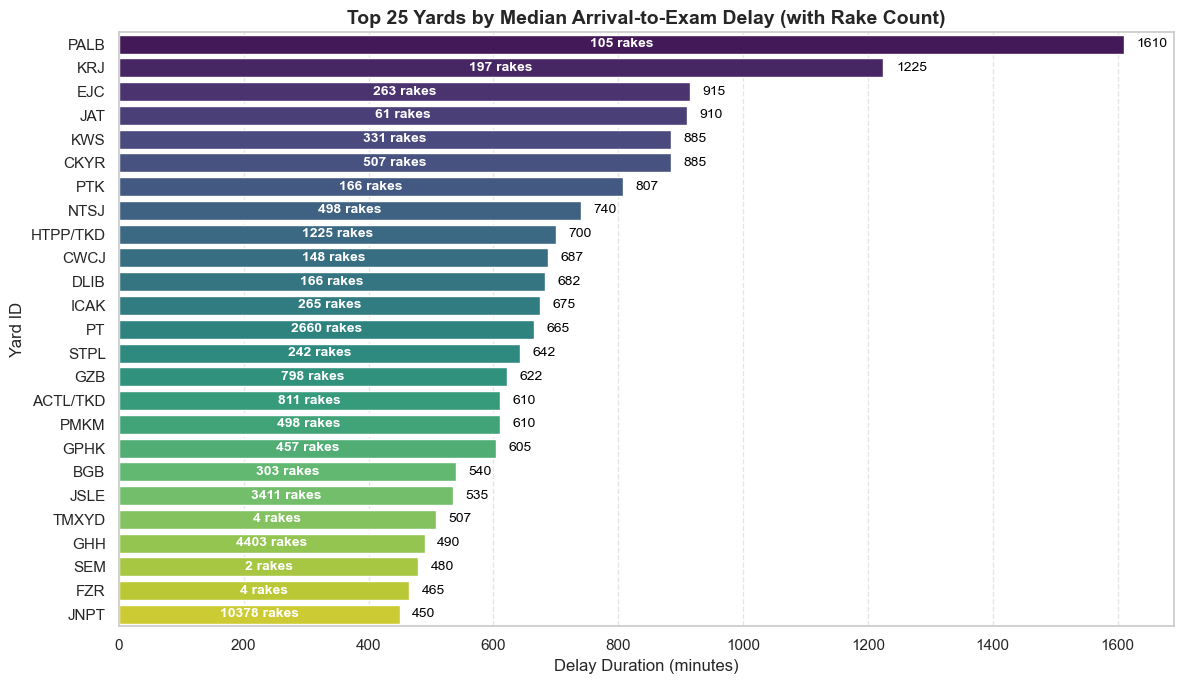

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Filter large delays
top_df = df[df["ar_to_ex_st"] < 20080]

# ✅ Step 2: Median delay per yard
median_delay = (
    top_df.groupby("yard_id")["ar_to_ex_st"]
    .median()
    .sort_values(ascending=False)
    .head(25)
)

# ✅ Step 3: Count of rakes per yard
rake_counts = top_df['yard_id'].value_counts()

# ✅ Step 4: Create plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x=median_delay.values,
    y=median_delay.index,
    palette=sns.color_palette("viridis", len(median_delay))
)

# ✅ Step 5: Add value & count labels
for i, (value, label) in enumerate(zip(median_delay.values, median_delay.index)):
    count = rake_counts.get(label, 0)
    ax.text(value + 20, i, f"{int(value)}", va='center', color='black', fontsize=10)
    ax.text(value / 2, i, f"{count} rakes", va='center', ha='center', color='white', fontsize=10, weight='bold')

# ✅ Step 6: Style
plt.title("Top 25 Yards by Median Arrival-to-Exam Delay (with Rake Count)", fontsize=14, weight='bold')
plt.xlabel("Delay Duration (minutes)")
plt.ylabel("Yard ID")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Top 25 yards with Fastest Duration Time [ar_to_ex_st]

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2253630649.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


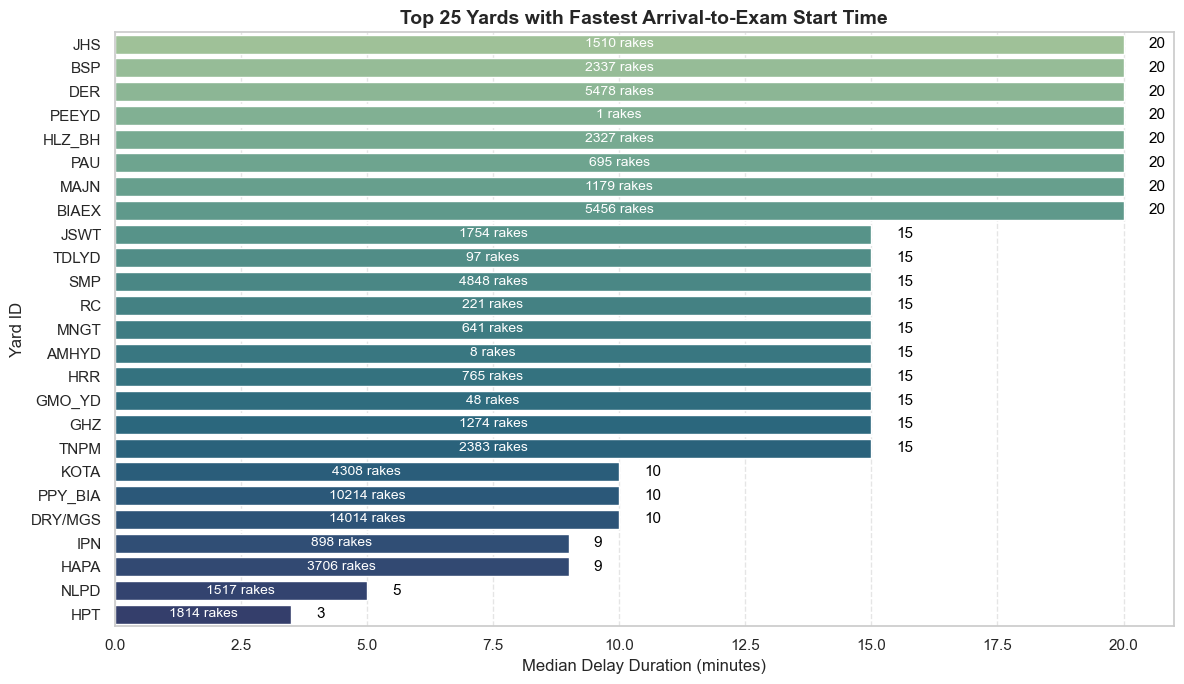

In [67]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

# ✅ Step 1: Filter outliers
filtered_df = df[df["ar_to_ex_st"] < 10080]

# ✅ Step 2: Median delay & rake counts (ascending → fastest)
median_delay = (
    filtered_df.groupby("yard_id")["ar_to_ex_st"]
    .median()
    .sort_values(ascending=True)  # Fastest first
    .head(25)
)

# ✅ Step 3: Rake count per yard
rake_counts = filtered_df[filtered_df["yard_id"].isin(median_delay.index)].groupby("yard_id").size()

# ✅ Merge into DataFrame (then sort descending for bottom-up display)
plot_df = pd.DataFrame({
    "median_delay": median_delay,
    "rake_count": rake_counts
}).sort_values("median_delay", ascending=False)  # ⬅️ Smallest at bottom

# ✅ Plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x=plot_df["median_delay"],
    y=plot_df.index,
    palette=sns.color_palette("crest", len(plot_df))
)

# ✅ Annotations
for i, (delay, rakes) in enumerate(zip(plot_df["median_delay"], plot_df["rake_count"])):
    # Delay just outside the bar
    ax.text(delay + 0.5, i, f"{int(delay)}", va='center', ha='left', color='black', fontsize=11)
    
    # Rake count inside the bar
    ax.text(delay / 2, i, f"{rakes} rakes", va='center', ha='center', color='white', fontsize=10)

# ✅ Styling
plt.title("Top 25 Yards with Fastest Arrival-to-Exam Start Time", fontsize=14, weight='bold')
plt.xlabel("Median Delay Duration (minutes)", fontsize=12)
plt.ylabel("Yard ID", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


####  Top 25 Rake Type wise Higest Duration Time [ar_to_ex_st]


C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\973863913.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


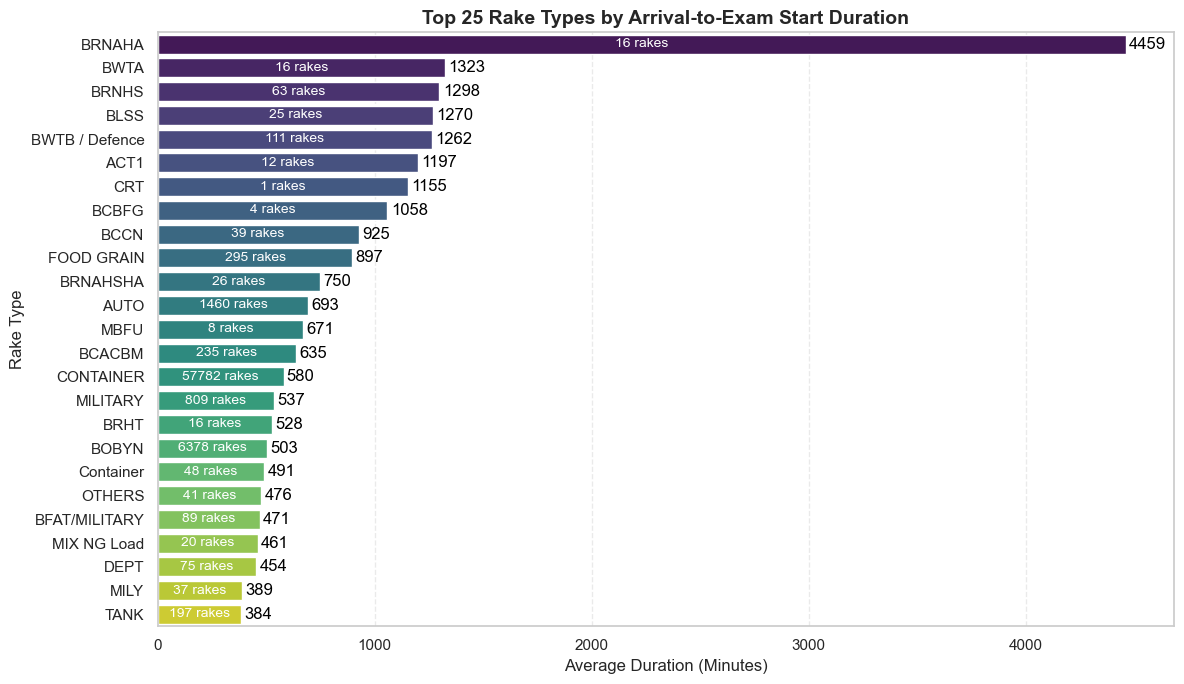

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Compute average delay and rake counts
rake_stats = df.groupby('rake_type').agg(
    avg_delay=('ar_to_ex_st', 'mean'),
    rake_count=('rake_id', 'count')
).sort_values(by='avg_delay', ascending=False).head(25)

# ✅ Plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    y=rake_stats.index,
    x=rake_stats['avg_delay'],
    palette='viridis'
)

# ✅ Add delay label on the right & rake count inside the bar
for i, (delay, rakes) in enumerate(zip(rake_stats['avg_delay'], rake_stats['rake_count'])):
    # Delay value label (right side of bar)
    ax.text(delay + 15, i, f"{int(delay)}", va='center', ha='left', color='black', fontsize=12)
    
    # Rake count inside the bar
    ax.text(delay / 2, i, f"{rakes} rakes", va='center', ha='center', color='white', fontsize=10)

# ✅ Styling
plt.title("Top 25 Rake Types by Arrival-to-Exam Start Duration", fontsize=14, weight='bold')
plt.xlabel("Average Duration (Minutes)")
plt.ylabel("Rake Type")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### Top 25 Rake Types with the Fastest Duration time [ar_to_ex_st]

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2406541420.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


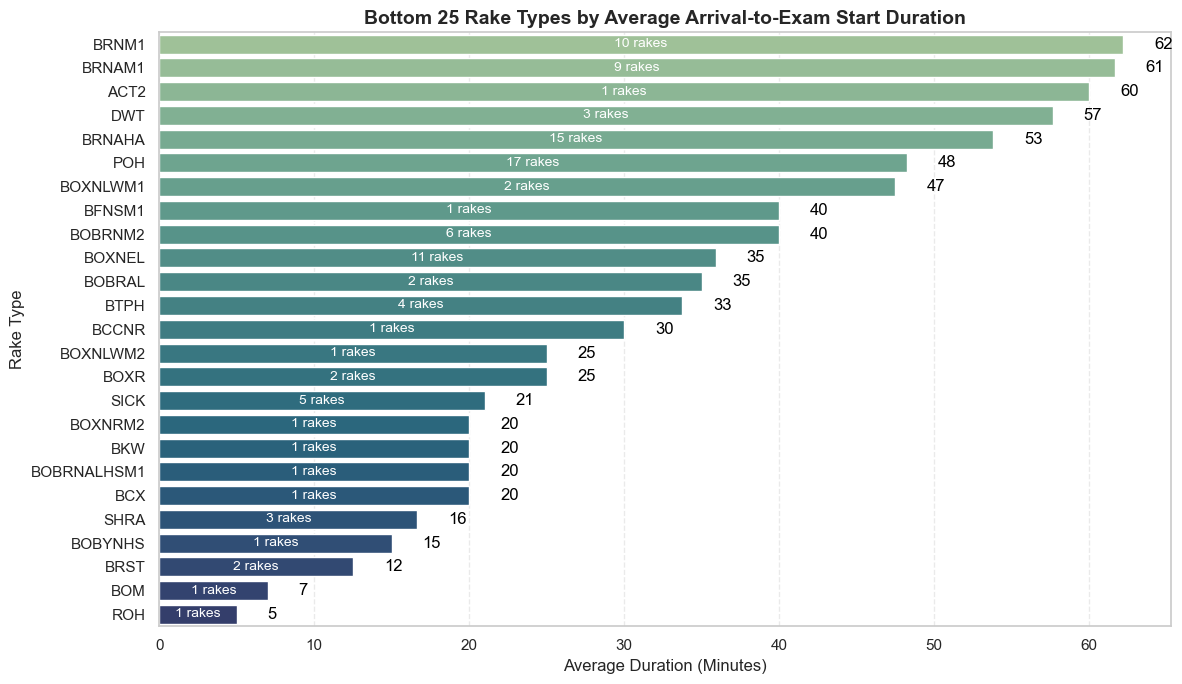

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Filter out extreme delays
filtered_df = df[df['ar_to_ex_st'] < 20080]

# ✅ Compute average delay and rake count
rake_stats = (
    filtered_df.groupby('rake_type')
    .agg(avg_delay=('ar_to_ex_st', 'mean'), rake_count=('rake_id', 'count'))
    .sort_values(by='avg_delay', ascending=True)
    .head(25)[::-1]  # Reverse to plot smallest at bottom
)

# ✅ Plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    y=rake_stats.index,
    x=rake_stats['avg_delay'],
    palette='crest'
)

# ✅ Add delay label and rake count using enumerate
for i, (delay, rakes) in enumerate(zip(rake_stats['avg_delay'], rake_stats['rake_count'])):
    # Delay value on right
    ax.text(delay + 2, i, f"{int(delay)}", va='center', ha='left', color='black', fontsize=12)
    # Rake count inside bar
    ax.text(delay / 2, i, f"{rakes} rakes", va='center', ha='center', color='white', fontsize=10)

# ✅ Styling
plt.title("Bottom 25 Rake Types by Average Arrival-to-Exam Start Duration", fontsize=14, weight='bold')
plt.xlabel("Average Duration (Minutes)")
plt.ylabel("Rake Type")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



#### Top BPC Categories wise Duration Time [ar_to_ex_st]


C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2309331452.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


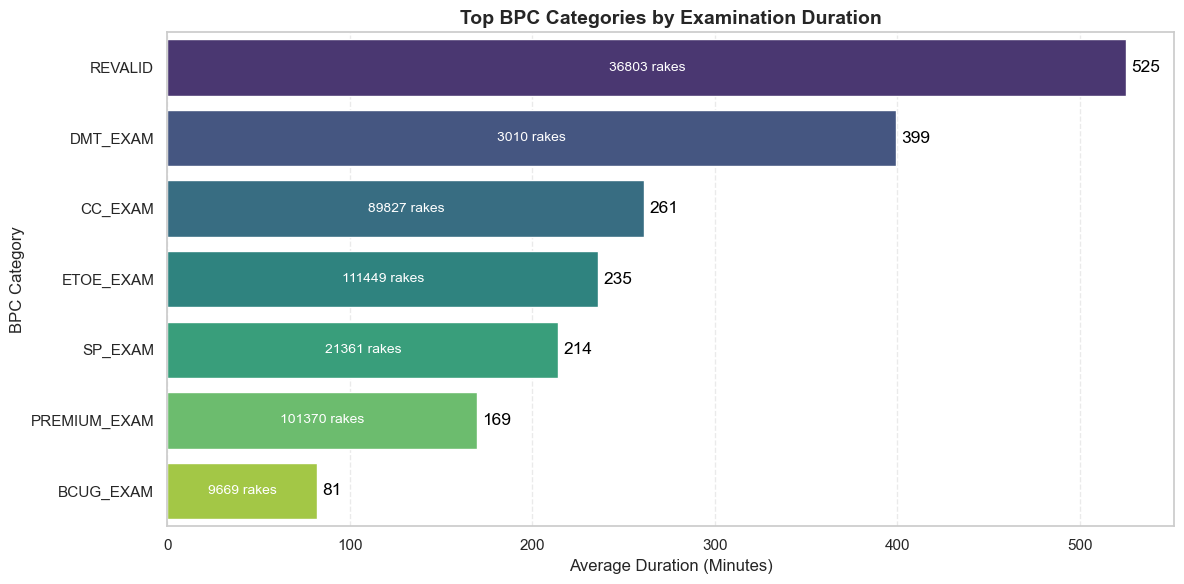

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Calculate average delay and rake count per BPC category
bpc_stats = (
    df.groupby('bpc_categ')
    .agg(avg_delay=('ar_to_ex_st', 'mean'), rake_count=('rake_id', 'count'))
    .sort_values(by='avg_delay', ascending=False)
    .head(20)
)

# ✅ Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    y=bpc_stats.index,
    x=bpc_stats['avg_delay'],
    palette='viridis'
)

# ✅ Add both labels (delay and rake count)
for i, (delay, rakes) in enumerate(zip(bpc_stats['avg_delay'], bpc_stats['rake_count'])):
    # Average delay label (right of bar)
    ax.text(delay + 3, i, f"{int(delay)}", va='center', ha='left', color='black', fontsize=12.5)
    # Rake count label (inside bar)
    ax.text(delay / 2, i, f"{rakes} rakes", va='center', ha='center', color='white', fontsize=10)

# ✅ Style
plt.title("Top BPC Categories by Examination Duration", fontsize=14, weight='bold')
plt.xlabel("Average Duration (Minutes)")
plt.ylabel("BPC Category")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



#### Yard Vise Arrival To Exam Start Time

In [71]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Create folder to save graphs
os.makedirs("yard_wise_delay_graphs", exist_ok=True)

# ✅ Loop through each unique yard
for yard in df_cleaned['yard_id'].unique():
    yard_df = df_cleaned[df_cleaned['yard_id'] == yard]

    # Skip if yard has no usable data
    if yard_df['rake_type'].isna().all() or yard_df['ar_to_ex_st'].isna().all():
        continue

    # ✅ Calculate median delay per rake type
    yard_delay_by_rake = (
        yard_df.groupby('rake_type')['ar_to_ex_st']
        .median()
        .sort_values(ascending=False)
        .reset_index()
    )

    if yard_delay_by_rake.empty:
        continue

    # 🎨 Colorful viridis palette
    colors = sns.color_palette("viridis", len(yard_delay_by_rake))

    # 📊 Plot
    plt.figure(figsize=(12, 6))
    ax = plt.barh(
        yard_delay_by_rake['rake_type'],
        yard_delay_by_rake['ar_to_ex_st'],
        color=colors
    )
    plt.gca().invert_yaxis()  # Top = highest delay
    plt.title(f"Rake-wise Duration Time in Yard: {yard}", fontsize=14)
    plt.xlabel("Duration Time (ar_to_ex_st) in Minutes")
    plt.ylabel("Rake Type")
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)

    # ✅ Add value labels to bars
    for i, (rake, value) in enumerate(zip(yard_delay_by_rake['rake_type'], yard_delay_by_rake['ar_to_ex_st'])):
        plt.text(value + 5, i, f"{int(value)}", va='center', ha='left', fontsize=9, color='black')

    plt.tight_layout()

    # ✅ Safe filename
    safe_yard = yard.replace("/", "_").replace("\\", "_")
    filename = f"yard_wise_delay_graphs/{safe_yard}_rake_delay.png"

    # 💾 Save and close
    plt.savefig(filename)
    plt.close()

print("✅ All yard-wise rake delay graphs saved in 'yard_wise_delay_graphs' folder with values displayed.")


✅ All yard-wise rake delay graphs saved in 'yard_wise_delay_graphs' folder with values displayed.


####  Heatmap of Feature Correlations (All Variables)

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\1827715165.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\pkf\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


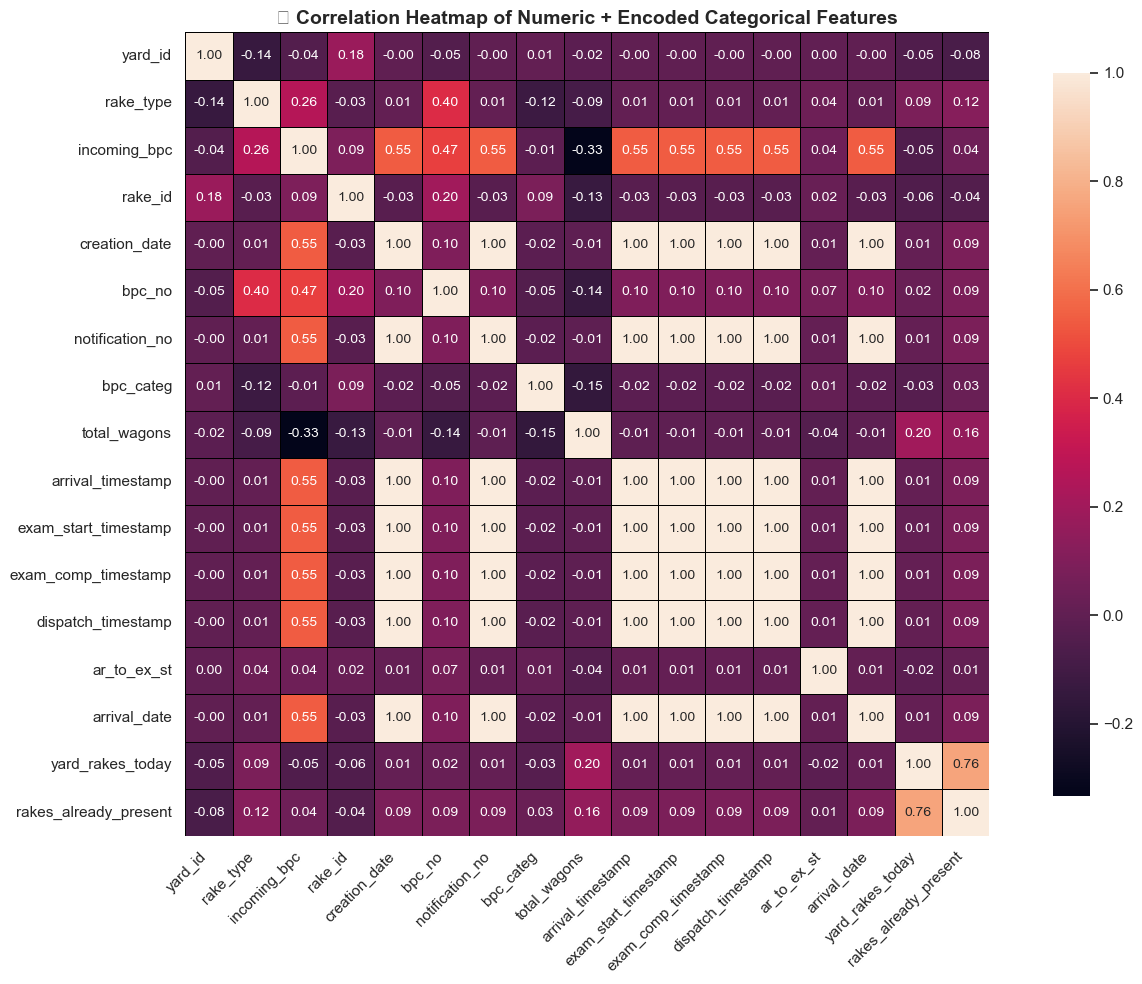

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ✅ Make a copy to avoid changing original data
df_corr = df.copy()

# ✅ Identify categorical columns
categorical_cols = df_corr.select_dtypes(include=['object', 'category']).columns.tolist()

# ✅ Encode categorical columns using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))
    label_encoders[col] = le

# ✅ Select all numeric + newly encoded categorical columns
numeric_df = df_corr.select_dtypes(include=['number'])

# ✅ Compute correlation matrix
correlation_matrix = numeric_df.corr()

# ✅ Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True, fmt='.2f',
    cmap='rocket',
    linewidths=0.5,
    linecolor='black',
    square=True,
    cbar_kws={'shrink': 0.9},
    annot_kws={"size": 10}
)
plt.title("🔍 Correlation Heatmap of Numeric + Encoded Categorical Features", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Delay Frequency  — Arrival to Exam Start

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2514063665.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\pkf\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


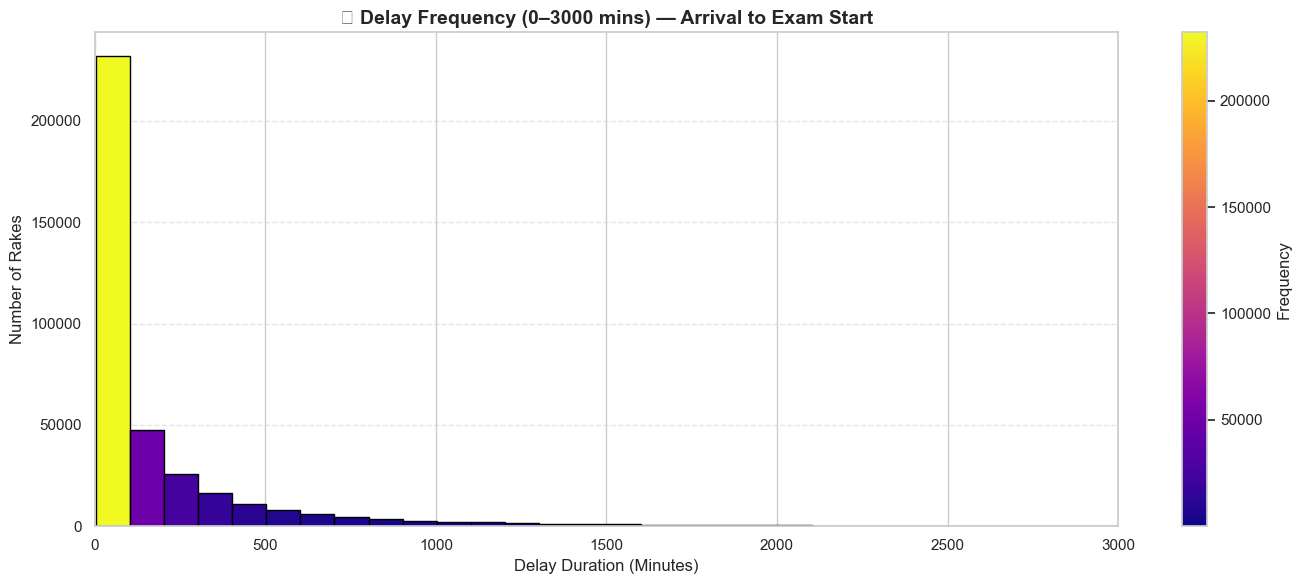

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Filter delays under 5000 minutes
filtered_df = df[df['ar_to_ex_st'] <= 5000]
data = filtered_df['ar_to_ex_st']

# ✅ Create histogram data
counts, bins = np.histogram(data, bins=50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ✅ Normalize counts and get colormap
norm = plt.Normalize(counts.min(), counts.max())
colors = plt.cm.plasma(norm(counts))  # 🔥 plasma-style

# ✅ Create figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# ✅ Plot bars with colors
for i in range(len(counts)):
    ax.bar(bin_centers[i], counts[i], width=(bins[1] - bins[0]), color=colors[i], edgecolor='black')

# ✅ Create and attach colorbar
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Frequency", fontsize=12)

# ✅ Styling
ax.set_title("🎯 Delay Frequency (0–3000 mins) — Arrival to Exam Start", fontsize=14, weight='bold')
ax.set_xlabel("Delay Duration (Minutes)", fontsize=12)
ax.set_ylabel("Number of Rakes", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_xlim(0, 3000)

plt.tight_layout()
plt.show()


##### Rake Already Present vs Delay

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2740511781.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box = sns.boxplot(x='rakes_bin', y='ar_to_ex_st', data=df, palette=colors)
C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2740511781.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delays = df.groupby('rakes_bin')['ar_to_ex_st'].mean()


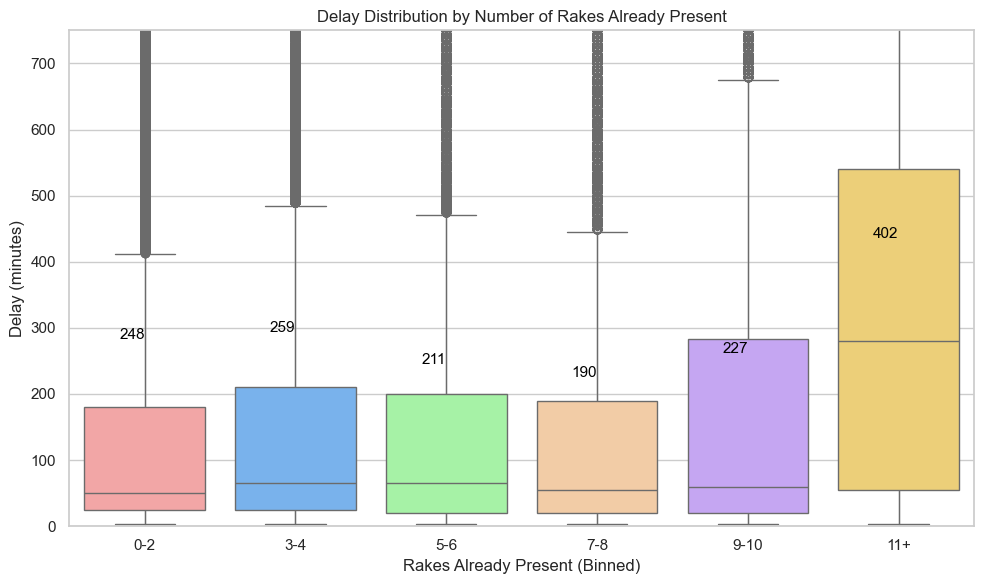

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Bin the rakes_already_present column
df['rakes_bin'] = pd.cut(df['rakes_already_present'], 
                         bins=[0,2,4,6,8,10,20], 
                         labels=['0-2','3-4','5-6','7-8','9-10','11+'])

# ✅ Define a color palette with as many colors as bins
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#C299FF', '#FFD966']  # 6 distinct colors

plt.figure(figsize=(10,6))

# ✅ Create the boxplot with custom colors
box = sns.boxplot(x='rakes_bin', y='ar_to_ex_st', data=df, palette=colors)

# ✅ Calculate average delay for each bin
avg_delays = df.groupby('rakes_bin')['ar_to_ex_st'].mean()

# ✅ Annotate average above each box
for i, bin_label in enumerate(avg_delays.index):
    avg = avg_delays[bin_label]
    plt.text(i, avg + 30, f'{avg:.0f}', ha='right', va='bottom', fontsize=11, color='black')

plt.title('Delay Distribution by Number of Rakes Already Present')
plt.xlabel('Rakes Already Present (Binned)')
plt.ylabel('Delay (minutes)')
plt.ylim(0, 750)
plt.grid(True)
plt.tight_layout()
plt.show()


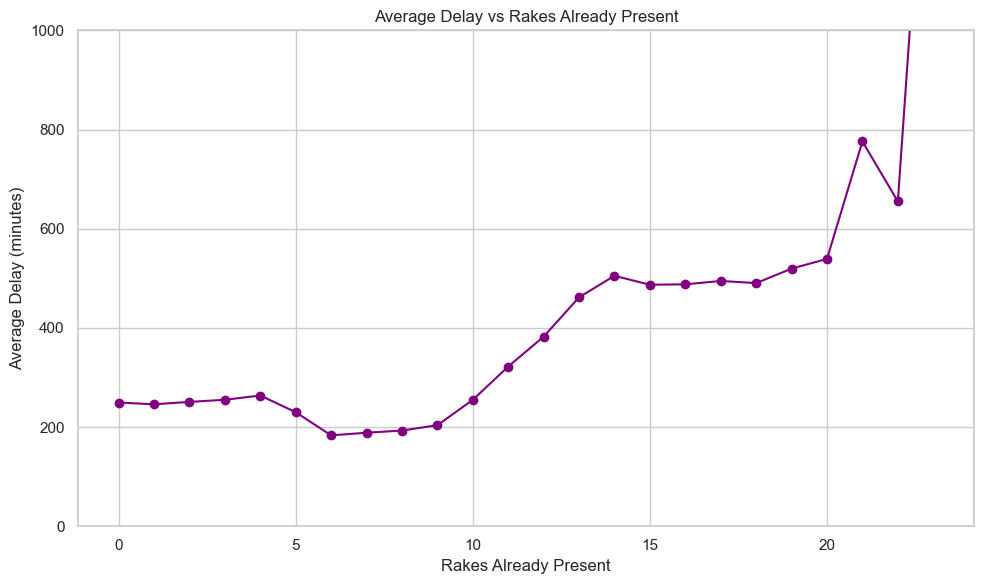

In [75]:
avg_delay = df.groupby('rakes_already_present')['ar_to_ex_st'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(avg_delay['rakes_already_present'], avg_delay['ar_to_ex_st'], marker='o', color='purple')
plt.title('Average Delay vs Rakes Already Present')
plt.xlabel('Rakes Already Present')
plt.ylabel('Average Delay (minutes)')
plt.ylim(0, 1000) 
plt.grid(True)
plt.tight_layout()
plt.show()


In [76]:
correlation = df[['rakes_already_present', 'ar_to_ex_st']].corr().iloc[0,1]
print("Correlation between rakes_already_present and delay:", round(correlation, 4))


Correlation between rakes_already_present and delay: 0.0061


#### Yearly Analysis

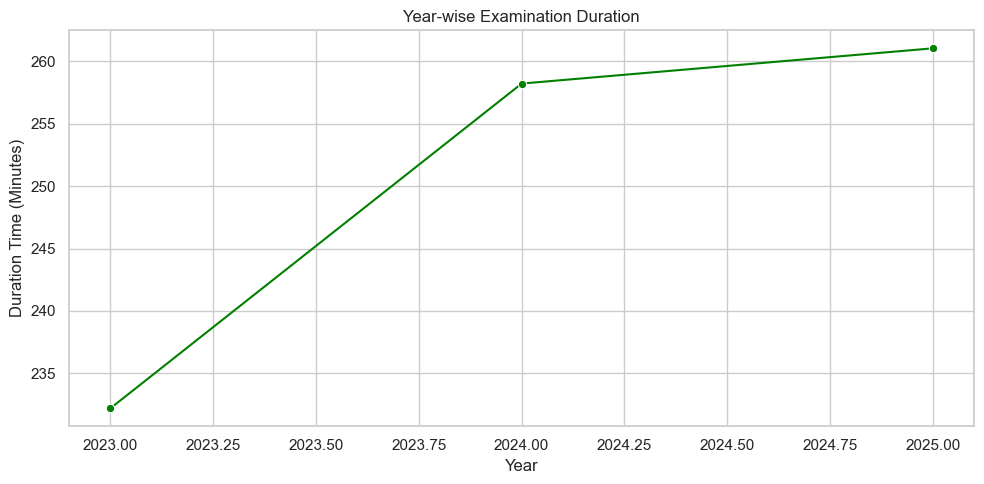

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Ensure timestamp and extract year
df['arrival_timestamp'] = pd.to_datetime(df['arrival_timestamp'], errors='coerce')
df['year'] = df['arrival_timestamp'].dt.year

# ✅ Group and plot
yearly = df.groupby('year')['ar_to_ex_st'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly.index, y=yearly.values, marker='o', color='green')
plt.title("Year-wise Examination Duration")
plt.xlabel("Year")
plt.ylabel("Duration Time (Minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Monthly Analysis

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\1349773108.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\pkf\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


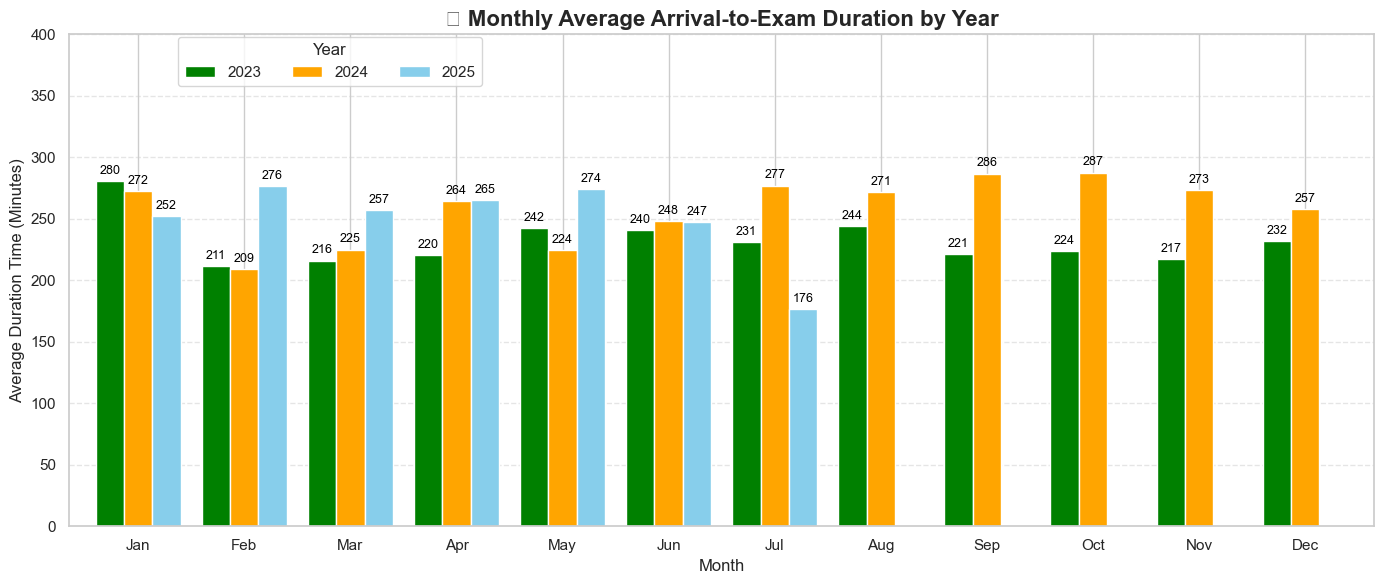

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Convert to datetime and extract year/month
df['arrival_timestamp'] = pd.to_datetime(df['arrival_timestamp'], errors='coerce')
df['year'] = df['arrival_timestamp'].dt.year
df['month'] = df['arrival_timestamp'].dt.month

# ✅ Compute monthly average 'ar_to_ex_st'
monthly_avg = df.groupby(['year', 'month'])['ar_to_ex_st'].mean().reset_index()

# ✅ Pivot for bar plotting (year = columns, month = index)
pivot_df = monthly_avg.pivot(index='month', columns='year', values='ar_to_ex_st').fillna(0)

# ✅ Ensure years are sorted (e.g., 2023, 2024, 2025)
pivot_df = pivot_df[sorted(pivot_df.columns)]

# ✅ Plot setup
fig, ax = plt.subplots(figsize=(14, 6))
colors = ['green', 'orange', 'skyblue','black']
ax = pivot_df.plot(kind='bar', width=0.8, color=colors, ax=ax)

# ✅ Add value labels on each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color='black')

# ✅ Style and legend
plt.title("📊 Monthly Average Arrival-to-Exam Duration by Year", fontsize=16, weight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Duration Time (Minutes)", fontsize=12)
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# ✅ Move legend to top in a single line
plt.legend(title='Year', bbox_to_anchor=(0.2, 0.88), loc='lower center', ncol=len(pivot_df.columns))

plt.ylim(0,400)
plt.tight_layout()
plt.show()


#### Weekly Analyse

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\2670894758.py:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\pkf\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


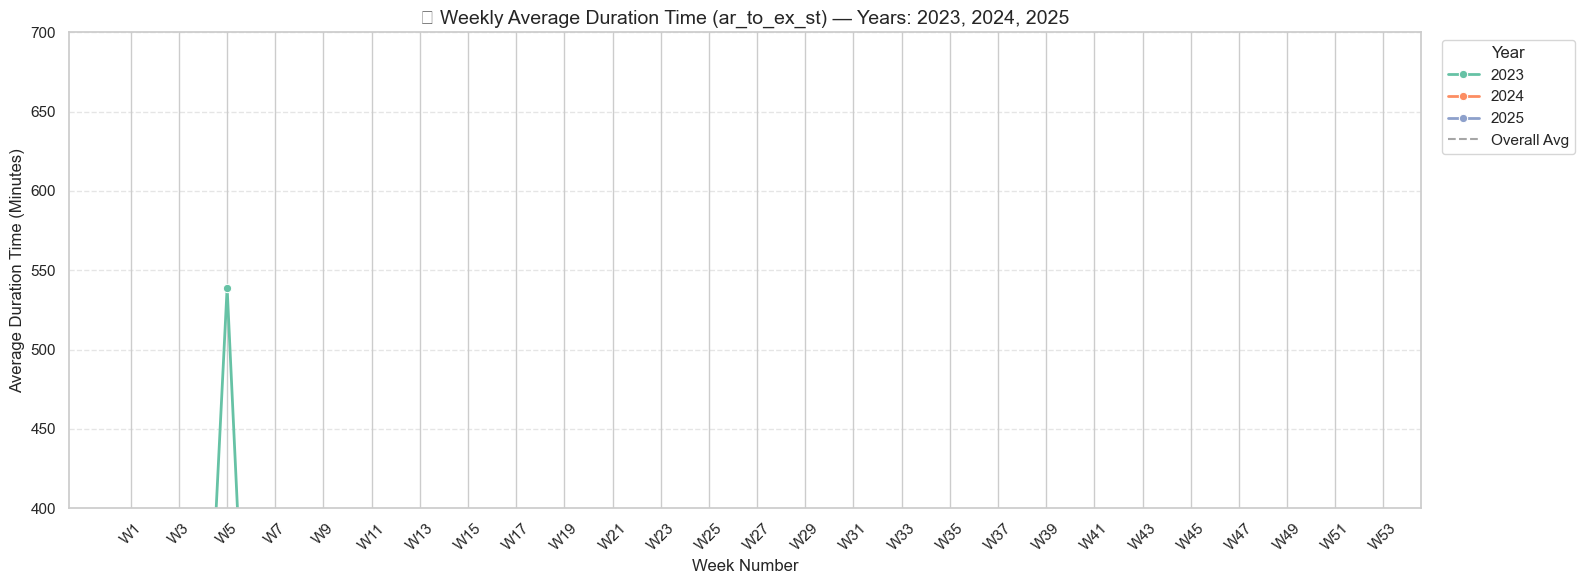

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Load and convert timestamp
df['arrival_timestamp'] = pd.to_datetime(df['arrival_timestamp'], errors='coerce')

# ✅ Extract week number and year
df['week'] = df['arrival_timestamp'].dt.isocalendar().week
df['year'] = df['arrival_timestamp'].dt.isocalendar().year

# ✅ Filter for specific years
df = df[df['year'].isin([2023, 2024, 2025])]

# ✅ Group by year-week and take average of target variable
weekly_avg = df.groupby(['year', 'week'])['ar_to_ex_st'].mean().reset_index()

# ✅ Pivot for plotting
pivot_df = weekly_avg.pivot(index='week', columns='year', values='ar_to_ex_st')
pivot_df = pivot_df.reindex(range(1, 54))  # Ensure all 53 weeks are present

# ✅ X-axis labels
week_labels = [f"W{w}" for w in pivot_df.index]

# ✅ Start plotting
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid", palette="Set2")  # Use cleaner color palette

# ✅ Plot each year line
for year in [2023, 2024, 2025]:
    if year in pivot_df.columns:
        sns.lineplot(x=week_labels, y=pivot_df[year], label=str(year), marker='o', linewidth=2)

# ✅ Improve readability
plt.title("📊 Weekly Average Duration Time (ar_to_ex_st) — Years: 2023, 2024, 2025", fontsize=14)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Average Duration Time (Minutes)", fontsize=12)
plt.ylim(400, 700)
plt.xticks(ticks=range(0, 53, 2), labels=week_labels[::2], rotation=45)  # Reduce X-ticks
plt.grid(axis='y', linestyle='--', alpha=0.5)

# ✅ Optional: Add average line
overall_avg = df['ar_to_ex_st'].mean()
plt.axhline(overall_avg, color='gray', linestyle='--', alpha=0.7, label='Overall Avg')

# ✅ Optional: Highlight spike (example: Week 6 of 2023)
if 2023 in pivot_df.columns and 6 in pivot_df.index:
    spike_value = pivot_df.loc[6, 2023]
    if pd.notna(spike_value) and spike_value > 800:
        plt.annotate('Spike (W6, 2023)', xy=('W6', spike_value), xytext=('W10', spike_value + 50),
                     arrowprops=dict(arrowstyle="->", color='red'), fontsize=9, color='red')

# ✅ Final touches
plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.show()


#### Weekday wise Duration Time [ar_to_ex_st]

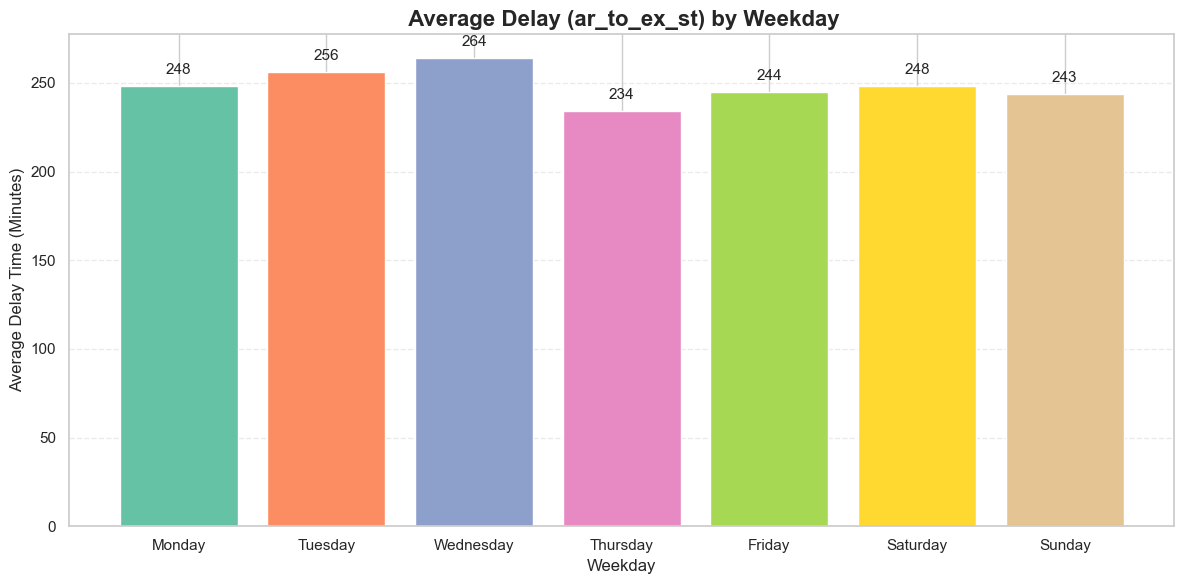

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Convert timestamp if not already
df['arrival_timestamp'] = pd.to_datetime(df['arrival_timestamp'], errors='coerce')

# ✅ Extract weekday
df['weekday'] = df['arrival_timestamp'].dt.day_name()

# ✅ Compute average delay per weekday
weekday_avg = (
    df.groupby('weekday')['ar_to_ex_st']
    .mean()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])  # correct order
)

# ✅ Plot
plt.figure(figsize=(12,6))
colors = sns.color_palette('Set2', n_colors=7)
bars = plt.bar(weekday_avg.index, weekday_avg.values, color=colors)

# ✅ Add value labels using enumerate
for i, value in enumerate(weekday_avg.values):
    plt.text(i, value + 5, f"{int(value)}", ha='center', va='bottom', fontsize=11)

# ✅ Styling
plt.title(" Average Delay (ar_to_ex_st) by Weekday", fontsize=16, weight='bold')
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Average Delay Time (Minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### Daily Analysis


C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\4280961005.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_by_hour.index, y=avg_delay_by_hour.values, palette='Blues')


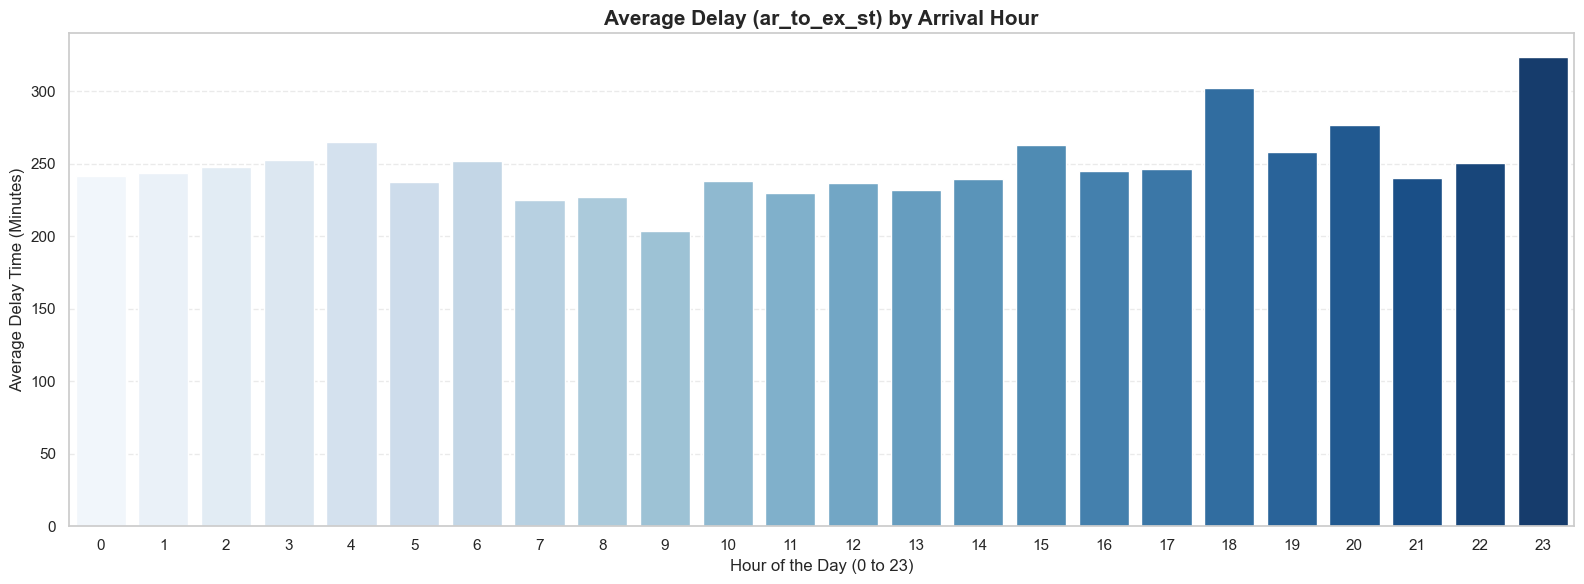

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Convert to datetime and extract hour
df['arrival_timestamp'] = pd.to_datetime(df['arrival_timestamp'], errors='coerce')
df['arrival_hour'] = df['arrival_timestamp'].dt.hour

# ✅ Group by hour and calculate average delay
avg_delay_by_hour = (
    df.groupby('arrival_hour')['ar_to_ex_st']
    .mean()
    .reindex(range(0, 24))  # hours 0 to 23
)

# ✅ Plot
plt.figure(figsize=(16, 6))
sns.barplot(x=avg_delay_by_hour.index, y=avg_delay_by_hour.values, palette='Blues')

plt.title("Average Delay (ar_to_ex_st) by Arrival Hour", fontsize=15, weight='bold')
plt.xlabel("Hour of the Day (0 to 23)", fontsize=12)
plt.ylabel("Average Delay Time (Minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### Rakes Already Present Before Next Arrival

In [82]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#  Create folder to save graphs
output_folder = "yard_rake_congestion_heatmaps"
os.makedirs(output_folder, exist_ok=True)

#  Loop through each unique yard in the dataset
for yard in df['yard_id'].dropna().unique():
    yard_df = df[df['yard_id'] == yard]

    # Skip yard if no usable data
    if yard_df['rake_type'].isna().all() or yard_df['rakes_already_present'].isna().all():
        continue

    #  Create heatmap data: rake_type × rakes already present before exam complete
    heat_data = pd.crosstab(
        yard_df['rake_type'],
        yard_df['rakes_already_present']
    )

    # Skip if empty
    if heat_data.empty:
        continue

    #  (Optional) Keep only top N rake types to keep graph clean
    top_rakes = yard_df['rake_type'].value_counts().head(15).index
    heat_data = heat_data.loc[heat_data.index.intersection(top_rakes)]

    #  Plot heatmap
    plt.figure(figsize=(14, 6))
    sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt='d', linewidths=.5, cbar=True)

    plt.title(f" Yard: {yard} — Rake Type vs. Rakes Already Present In Yard", fontsize=14)
    plt.xlabel("Rakes Already Present ")
    plt.ylabel("Rake Type")
    plt.tight_layout()

    #  Safe filename
    safe_yard = str(yard).replace("/", "_").replace("\\", "_").replace(":", "_")
    file_path = os.path.join(output_folder, f"{safe_yard}_congestion_heatmap.png")

    #  Save and close
    plt.savefig(file_path)
    plt.close()

print(f"✅ All yard-wise rake congestion heatmaps saved in '{output_folder}' folder.")


✅ All yard-wise rake congestion heatmaps saved in 'yard_rake_congestion_heatmaps' folder.


##### Boxplot: Arrival to Exam Start Time — Before vs After Outlier Removal

C:\Users\pkf\AppData\Local\Temp\ipykernel_10524\4110416708.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='ar_to_ex_st', data=combined_df, palette=['#87CEFA', '#FFB347'])


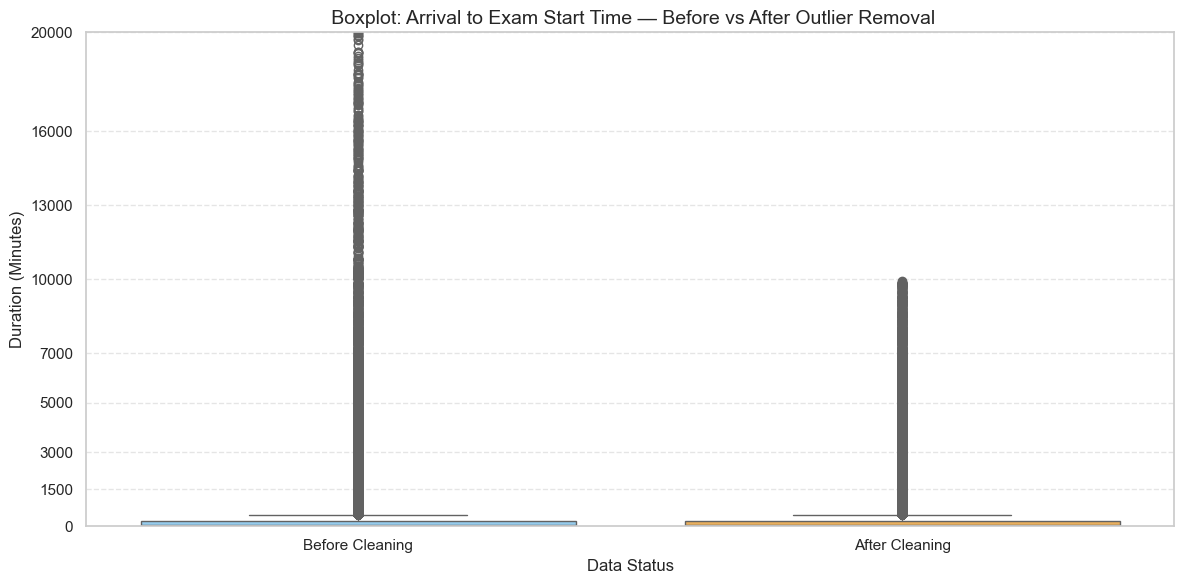

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Prepare before and after DataFrames
df_before = df.copy()
df_after = df[df['ar_to_ex_st'] <= 10000].copy()  # ⏱️ Apply threshold

# 📌 Add status column
df_before['status'] = 'Before Cleaning'
df_after['status'] = 'After Cleaning'

# 📌 Combine both
combined_df = pd.concat([df_before, df_after])

# ✅ Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='ar_to_ex_st', data=combined_df, palette=['#87CEFA', '#FFB347'])

# ✅ Set custom Y-axis limits and ticks
plt.ylim(0, 20000)
plt.yticks([0,1500, 3000, 5000, 7000, 10000, 13000, 16000, 20000])

# ✅ Labels and title
plt.title(" Boxplot: Arrival to Exam Start Time — Before vs After Outlier Removal", fontsize=14)
plt.xlabel("Data Status")
plt.ylabel("Duration (Minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Data Cleaning

#### IQR Method

In [84]:
df = pd.read_csv("Updated_dataset.csv", low_memory=False)

# ✅ Step 2: Encode rake_id numerically (same rake gets same number)
df['rake_id'] = df['rake_id'].astype(str)  # Ensure rake_id is string
df['rake_id_num'] = df['rake_id'].astype('category').cat.codes

# 🔁 Function to remove outliers yard-wise using IQR
def remove_outliers_by_yard(df, group_col='yard_id', target_col='ar_to_ex_st', final_path='cleaned_dataset.csv'):
    cleaned_rows = []
    outlier_log = []

    for yard, group in df.groupby(group_col):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        filtered = group[(group[target_col] >= lower_bound) & (group[target_col] <= upper_bound)]
        removed_count = len(group) - len(filtered)

        if removed_count > 0:
            outlier_log.append({
                'yard_id': yard,
                'original_count': len(group),
                'removed_outliers': removed_count
            })

        cleaned_rows.append(filtered)

    # ✅ Combine all cleaned groups
    df_cleaned = pd.concat(cleaned_rows, ignore_index=True)

    # ✅ Summary DataFrame
    outlier_df = pd.DataFrame(outlier_log)

    # 🧾 Report
    print("✅ Outlier removal complete.")
    print(f"📉 Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")
    print("📌 Top affected yards by outlier removal:")
    print(outlier_df.sort_values(by='removed_outliers', ascending=False).head(10))
    print(outlier_df.sort_values(by='removed_outliers', ascending=False).tail(10))
    

    # 💾 Final save after outlier removal
    df_cleaned.to_csv(final_path, index=False)
    print(f"✅ Final cleaned (with outliers removed) data saved to: {final_path}")

    return df_cleaned, outlier_df

final_path = 'cleaned_dataset.csv'
df_cleaned, outlier_summary = remove_outliers_by_yard(df, final_path=final_path)


✅ Outlier removal complete.
📉 Original rows: 373584, Cleaned rows: 335328
📌 Top affected yards by outlier removal:
        yard_id  original_count  removed_outliers
160     PPY_BIA           10215              2831
49      DRY/MGS           14018              1905
139         NKJ            9874              1255
181         SMP            4851               836
23          BSL            7424               744
161        PRDP            6018               707
9           BAD            1950               659
19   BNDM Ex Yd            6738               617
14        BIAEX            5457               604
91         JNPT           10378               564
    yard_id  original_count  removed_outliers
39      CWA              14                 2
61        G              28                 2
50      DRZ              20                 2
101    KIIP              25                 2
127     MQR             110                 1
60      FZR               4                 1
5     AMHYD  

### Data Preprocessing & Guided Ordinal Encoding
### Model Training, Tuning, and Evaluation


#### XGBoost Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ XGBoost Model Evaluation
📊 MAE: 77.95 minutes
📈 R² Score: 0.6212
🏆 Best Params: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 10, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}


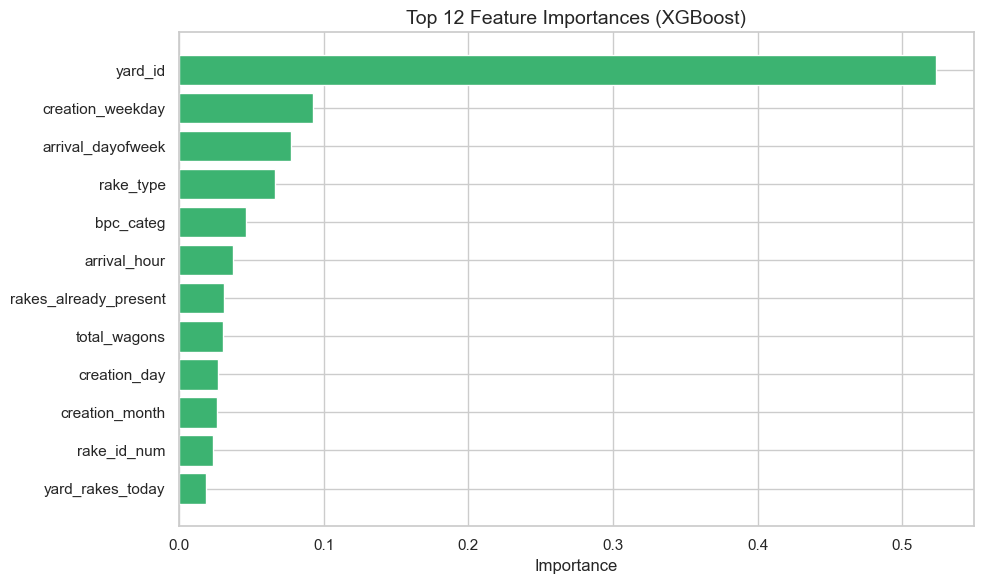

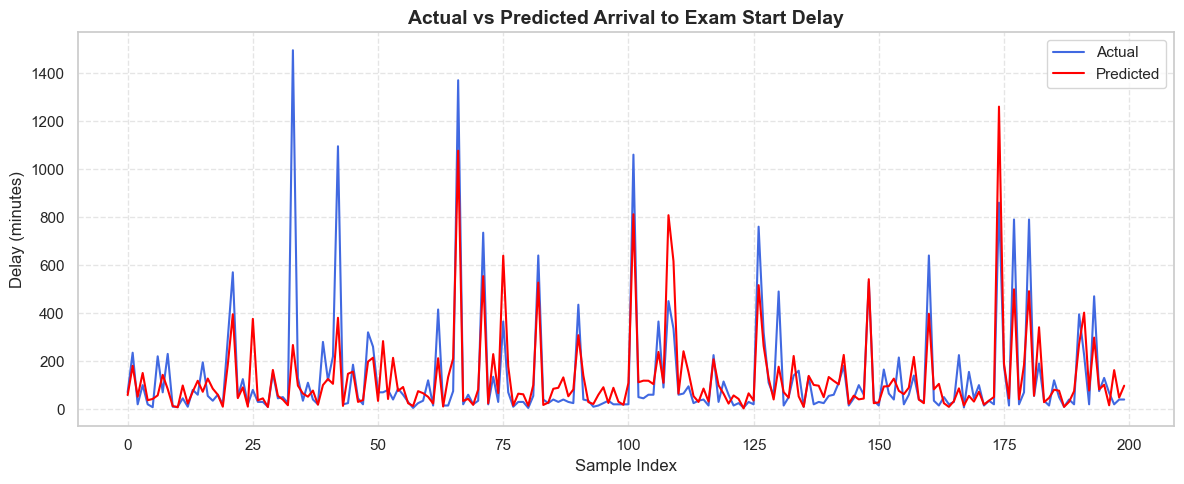

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# ------------------ STEP 1: Data Preprocessing ------------------

def preprocess_and_encode(csv_path="cleaned_dataset.csv", target='ar_to_ex_st'):
    df = pd.read_csv(csv_path, low_memory=False)

    # ✅ Ensure rake_id is string and encode consistently
    df['rake_id'] = df['rake_id'].astype(str)
    df['rake_id_num'] = df['rake_id'].astype('category').cat.codes  # same rake_id = same code

    # ✅ Convert timestamps
    df['arrival_timestamp'] = pd.to_datetime(df['arrival_timestamp'], errors='coerce')
    df['creation_date'] = pd.to_datetime(df['creation_date'], errors='coerce')

    # ✅ Extract time-based features
    df['arrival_hour'] = df['arrival_timestamp'].dt.hour
    df['arrival_dayofweek'] = df['arrival_timestamp'].dt.dayofweek
    df['creation_day'] = df['creation_date'].dt.day
    df['creation_month'] = df['creation_date'].dt.month
    df['creation_weekday'] = df['creation_date'].dt.dayofweek

    # ✅ Final selected features
    features = [
        'yard_id', 'rake_type', 'bpc_categ',
        'total_wagons', 'rakes_already_present', 'yard_rakes_today',
        'arrival_hour', 'arrival_dayofweek',
        'creation_day', 'creation_month', 'creation_weekday', 'rake_id_num'
    ]
    df = df[features + [target]].copy()

    # ✅ Handle missing
    categorical_cols = ['yard_id', 'rake_type', 'bpc_categ']
    numeric_cols = [col for col in features if col not in categorical_cols]

    for col in categorical_cols:
        df[col] = df[col].astype(str).fillna("missing")
    df.dropna(subset=numeric_cols + [target], inplace=True)

    # ✅ Guided encoding for categorical vars based on delay mean
    guided_mappings = {}
    for col in categorical_cols:
        mapping = df.groupby(col)[target].mean().sort_values().reset_index()
        mapping[f'{col}_enc'] = range(len(mapping))
        guided_mappings[col] = dict(zip(mapping[col], mapping[f'{col}_enc']))
        df[col] = df[col].map(guided_mappings[col])

    # ✅ Final data
    X = df.drop(columns=[target])
    y = df[target]

    # ✅ Column transformer for numeric scaling
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols)
    ], remainder='passthrough')

    return X, y, preprocessor, numeric_cols, categorical_cols

# ------------------ STEP 2: Train & Evaluate ------------------

def train_and_evaluate(X, y, preprocessor, numeric_cols, categorical_cols):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        verbosity=0,
        random_state=42
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb)
    ])

    param_grid = {
        'model__n_estimators': [100, 150, 200],
        'model__max_depth': [4, 6, 8, 10],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    }

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,## HYPER parameter ke liye combination 
        n_iter=20,
        scoring='neg_mean_absolute_error',
        cv=3,
        verbose=1,
        random_state=42,    #har baar same output aaye
        n_jobs=-1    # CPU core use in parallel for fast tune
    )

    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    # ✅ Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n✅ XGBoost Model Evaluation")
    print(f"📊 MAE: {mae:.2f} minutes")
    print(f"📈 R² Score: {r2:.4f}")
    print("🏆 Best Params:", search.best_params_)

    # ✅ Feature Importance
    model_final = best_model.named_steps['model']
    feature_names = numeric_cols + categorical_cols
    importances = model_final.feature_importances_
    indices = np.argsort(importances)[::-1]

    TOP_N = min(15, len(feature_names))
    top_idx = indices[:TOP_N]

    plt.figure(figsize=(10, 6))
    plt.title(f"Top {TOP_N} Feature Importances (XGBoost)", fontsize=14)
    plt.barh(range(TOP_N), importances[top_idx][::-1], color='mediumseagreen')
    plt.yticks(range(TOP_N), [feature_names[i] for i in top_idx][::-1])
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # ✅ Actual vs Predicted Graph (Line Plot for first 200 points)
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.values[:200], label='Actual', linestyle='-', color='royalblue')
    plt.plot(y_pred[:200], label='Predicted', linestyle='-', color='red')
    plt.title("Actual vs Predicted Arrival to Exam Start Delay", fontsize=14, weight='bold')
    plt.xlabel("Sample Index")
    plt.ylabel("Delay (minutes)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------ RUN ------------------

X, y, preprocessor, numeric_cols, categorical_cols = preprocess_and_encode("cleaned_dataset.csv")
train_and_evaluate(X, y, preprocessor, numeric_cols, categorical_cols)
